#3.4.3 Виды нейронных сетей для задач **NLP**

Ранее мы рассматривали различные методики оцифровки текстов и работы с ними в лекции. А сейчас рассмотрим эти приёмы работы на примере оценки тональности статей. Ссылка на набор данных прведена в конце ноутбука.

В данном разделе посмотрим, как работать с "мешком слов" и различными векторными моделями. Рассмотрим нейросети как полносвязные, так и работающие со слоем Embedding. Модели на основе LSTM не покажем, т.к. материала очень много, а сейчас "нишу" этих моделей занимают сети-трансформеры. Сеть LSTM может быть получена добавлением слоя LSTM после Embedding, например, или после входного слоя Dence. Это и будет вашим домашним заданием.
А в следующем пункте рассмотрим извлечение эмбеддингов (здесь подразумевается не слой, а векторные представления слов) с помощью знаменитой модели-трансформера BERT.

# Импортируем  библиотеки

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
import json

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Embedding, SpatialDropout1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy

In [ ]:
PPRINT_WIDTH = 160 # константа для функции pprint, количество символов в одной строке при выводе

# Загрузка и знакомство с данными

In [ ]:
path_train = '/content/train.json'

with open(path_train, 'r') as f:
    data_train = json.loads(f.read())

text_data = pd.DataFrame(data_train)
text_data.drop(columns = 'id', inplace = True)
print(text_data.shape)
text_data.head()

(8263, 2)


,text,sentiment
0,Досудебное расследование по факту покупки ЕНПФ...,negative
1,Медики рассказали о состоянии пострадавшего му...,negative
2,"Прошел почти год, как железнодорожным оператор...",negative
3,По итогам 12 месяцев 2016 года на территории р...,negative
4,Астана. 21 ноября. Kazakhstan Today - Агентств...,negative


In [ ]:
text_data.shape # выведем размерность нашего DataFrame

(10319, 2)

In [ ]:
# подсчитаем количество уникальных классов отзывов
n_classes = text_data['sentiment'].nunique()
n_classes

3

In [ ]:
# посмотрим количество записей по каждому классу
text_data['sentiment'].value_counts()

neutral     4034
positive    2795
negative    1434
Name: sentiment, dtype: int64

In [ ]:
#  сделаем разделение наших данных на обучение тест с учетом стратификации
train_index, test_index = train_test_split(np.arange(text_data.shape[0]), stratify = text_data['sentiment'])

x_train_raw = text_data.iloc[train_index, 0].values
y_train_raw = text_data.iloc[train_index, 1].values
x_test_raw = text_data.iloc[test_index, 0].values
y_test_raw = text_data.iloc[test_index, 1].values

In [ ]:
# посмотрим на размерность наших данных
x_train_raw.shape, x_test_raw.shape

((6197,), (2066,))

In [ ]:
# посмотрим произвольную  запись (пока "сырой" текст) в обучающей выборке
pprint(x_train_raw[1], width=PPRINT_WIDTH)

('Альберт Рау: транспортная структура Алматы полностью готова Насколько транспортная структура Алматы готова к обслуживанию гостей и участников Универсиады – '
 '2017, сообщил в ходе заседания правительства первый вице-министр по инвестициям и развитию РК Альберт Рау, передает корреспондент Total.kz. \n'
 '\n'
 ' «Специалистами гражданской авиации совместно с коллегами с таможенного комитета и сотрудниками пограничной службы, была проведена инспекторская проверка '
 'готовности международного аэропорта Алматы. Техника обеспечена полностью на все случаи. \n'
 '\n'
 ' В среднем у нас пассажиропоток 360 тыс. пассажиров в месяц. Пик в августе месяце достигает почти 600, поэтому запас есть. В среднем хронометраж показал до '
 'одной минуты на обслуживание одного пассажира. Пограничный контроль будет осуществляться через 42 кабины паспортного контроля и также отдельно по '
 'VIP-входам. Таким образом, аэропорт полностью готов. \n'
 '\n'
 ' В области железнодорожного транспорта по узлу Алматы

In [ ]:
# посмотрим на класс данной записи
y_train_raw[1]

'neutral'

# Базовые алгоритмы обработки текстов, с использованием Keras

Keras не является специализированной библиотекой по работе с естественным языком. Тем не менее, в Keras предусмотрены инструменты, которые позволяют нам быстро произвести обработку текстов для подачи их в нейронную сеть.
К таким инструментам можно отнести Tokenizer и Embedding слой.

## Использование OHE подхода

Первым, базовым алгоритмом "векторизации" текста является OHE (One Hot Encoding)  нашего мешка слов.

Алгоритм заключается в следующем:
1. Мы разбиваем текст на отдельные единицы смысла - токены. В простейшем случае один токен равен одному слову.
2. Мы считаем, сколько раз каждый токен встретился во всех наших текстах.
3. Выбираем **NUM_WORDS**   - количество слов, которые будем учитывать в нашей модели. Скорее всего **NUM_WORDS** будет меньше, чем общее количество слов в обучающих текстах.
4. Упорядочим все слова по частоте и выберем **NUM_WORDS** самых часто используемых слов.
5. Зададим специальный токен UNKNOWN для кодирования слов, не вошедших в самые часто встречаемые слова.
6. Токену UNKNOWN присвоим номер 1, все остальные слова также пронумеруем числами от 2 до **NUM_WORDS** + 1.
7. Индес 0 пока не используем, он нам понадобится для заадчи выравнивания последовательностей.

Теперь любой текст мы можем закодировать вектором длинной **NUM_WORDS** + 1.
*  Если слово с номером (индексом) i присутствует в тексте, то в ячейку с этим номером мы ставим 1
*  Если слово с номером (индексом) i в тексте не встречается, то в ячейку с этим номером мы ставим 0

### Tokenizer + OHE формат

В данном разделе мы будем использовать специальный объект Keras Tokenizer.
У Tokenizer есть несколько основных методов, помогающим нам в работе с текстами:
1. fit_on_texts - обновляет внутреннюю лексику на основе списка текстов. Он предобрабатывает текст, может привести слова к нижнему регистру, убирает лишние "мусорные" символы. Затем он создает словарный индекс на основании частоты слов.
2. texts_to_sequences - преобразует каждый текст в текстах в последовательность целых чисел (индексов)
3. sequences_to_texts - делает обратное преобразование последовательности индексов в слова
4. text_to_matrix - преобразует наши тексты в вектора в формате One Hot Encoding

После обучения Tokenizer нам доступны:
1. Словарь index_word - соответствие индексов и слов (токенов)
2. Словарь word_index - соответствие слов (токенов) и индексов


In [ ]:
NUM_WORDS = 20000 # константа, максимальное количество слов, которые будет учитывать наша модель

# создадим наш Токенайзер
tokenizer = Tokenizer(num_words=NUM_WORDS, # максимальное количество слов, которые будет учитывать наш токенайзер
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', # символы, которые он токенайзер будет фильтровать
                      lower=True,  #приводятся ли все символы к нижнему регситру
                      split=' ',  # символ, по которому происходит разделение на слова (токены)
                      char_level=False,  # являются ли токенами отдельные буквы
                      oov_token='UNKNOWN' # токен для неизвестных слов
                     )

tokenizer.fit_on_texts(x_train_raw) # обучим наш токенайзер на обучающих текстах

In [ ]:
tokenizer.index_word[5] # посмотрим, какое слово хранится в словаре токенайзера с индексом 5

'по'

In [ ]:
x_train_seq = tokenizer.texts_to_sequences(x_train_raw) # преобразуем наши тексты в последовательность токенов (индексов слов)

In [ ]:
pprint(x_train_seq[1], compact=True, width=PPRINT_WIDTH) # посмотрим, как закодирована один из отзывов

[5489, 3420, 5679, 3135, 53, 492, 4316, 1374, 5679, 3135, 53, 4316, 13, 8050, 2451, 3, 547, 1299, 48, 231, 2, 174, 630, 206, 246, 317, 109, 5, 311, 3, 165, 31,
 5489, 3420, 232, 536, 2582, 68, 5438, 1998, 2765, 373, 6, 5545, 6, 1038, 184, 3, 4929, 8515, 343, 136, 2161, 1, 1753, 3524, 518, 1925, 53, 4831, 8837, 492, 4,
 36, 4274, 2, 1170, 40, 130, 12639, 6188, 94, 683, 2, 836, 5606, 2, 2093, 4590, 9014, 399, 1857, 229, 7404, 65, 2, 1170, 1, 2462, 19, 503, 7405, 4, 2463, 447,
 18288, 18289, 1214, 33, 1791, 119, 1351, 1, 1, 526, 3, 23, 3048, 5, 10620, 1, 411, 396, 4202, 492, 2833, 2, 37, 1814, 502, 5, 1, 53, 1, 166, 6189, 1540, 882,
 23, 65, 1, 593, 5, 534, 81, 1, 4, 356, 339, 2161, 229, 23, 4641, 492, 65, 411, 396, 11412, 5679, 3135, 492, 2084, 9736, 1, 2463, 2451, 3, 547, 1299, 4203, 246,
 317, 109, 811, 2582, 68]


In [ ]:
# а теперь попробуем сделать обратное декодирование нашей последовательности в текст
# это позволит нам понять, какие данные видит нейронная сеть
text = ' '
for i in x_train_seq[1]:
    text += tokenizer.index_word[i] + ' '
pprint(text, width=PPRINT_WIDTH)

(' альберт рау транспортная структура алматы полностью готова насколько транспортная структура алматы готова к обслуживанию гостей и участников универсиады '
 '2017 сообщил в ходе заседания правительства первый вице министр по инвестициям и развитию рк альберт рау передает корреспондент total kz специалистами '
 'гражданской авиации совместно с коллегами с таможенного комитета и сотрудниками пограничной службы была проведена UNKNOWN проверка готовности международного '
 'аэропорта алматы техника обеспечена полностью на все случаи в среднем у нас пассажиропоток 360 тыс пассажиров в месяц пик в августе месяце достигает почти '
 '600 поэтому запас есть в среднем UNKNOWN показал до одной минуты на обслуживание одного пассажира пограничный контроль будет осуществляться через 42 UNKNOWN '
 'UNKNOWN контроля и также отдельно по vip UNKNOWN таким образом аэропорт полностью готов в области железнодорожного транспорта по UNKNOWN алматы UNKNOWN 30 '
 'пар пассажирских поездов также есть UNKNOWN с

In [ ]:
# Преобразуем наши текстовые данные в формат One Hot Encoding
x_train_01 = tokenizer.texts_to_matrix(x_train_raw)
x_test_01 = tokenizer.texts_to_matrix(x_test_raw)

In [ ]:
x_train_01.shape # посмотрим на форму полученного массива с обучающими данными

(6197, 20000)

In [ ]:
# закодируем нашу целевую переменную (класс отзыва) в формат OHE для подачи в нейронную сеть
target_encoeder = OneHotEncoder(sparse=False) # создадим объект Encoder
target_encoeder.fit(y_train_raw.reshape([-1, 1])) # обучим его на целевом признаке из обучающих данных

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(sparse=False, sparse_output=False)

In [ ]:
# сохраним названия классов в отдельную переменную, это понадобится нам на этапе предсказани
classes_names = target_encoeder.categories_[0] # названия классов хранятся в .categories_[0]
classes_names

array(['negative', 'neutral', 'positive'], dtype=object)

In [ ]:
# приведем наши целевые переменные из называний в формат OHO для подачи в нейронную сеть
y_train_01 = target_encoeder.transform(y_train_raw.reshape([-1, 1]))
y_test_01 = target_encoeder.transform(y_test_raw.reshape([-1, 1]))

In [ ]:
y_train_01.shape # посмотрим на размерность полученных данных

(6197, 3)

### Создание и обучение модели

In [ ]:
# создадим простую модель с одним внутренним полносвязным слоем
model01 = Sequential()
model01.add(Dense(64, input_dim=NUM_WORDS, activation='relu'))
model01.add(BatchNormalization())
model01.add(Dropout(0.4))
model01.add(Dense(n_classes,activation='softmax'))

model01.compile(optimizer=Adam(learning_rate=0.001),  loss='categorical_crossentropy',  metrics=['accuracy'])

model01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1280064   
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1,280,515
Trainable params: 1,280,387
Non-trainable params: 128
_________________________________________________________________


In [ ]:
# обучим модель
model01.fit(x = x_train_01,  y = y_train_01, epochs = 5, verbose = 1, validation_data= (x_test_01, y_test_01))

Epoch 1/5
194/194 [==============================] - 3s 13ms/step - loss: 0.9955 - accuracy: 0.5951 - val_loss: 0.7239 - val_accuracy: 0.7076
Epoch 2/5
194/194 [==============================] - 2s 12ms/step - loss: 0.5576 - accuracy: 0.7865 - val_loss: 0.6891 - val_accuracy: 0.7183
Epoch 3/5
194/194 [==============================] - 2s 11ms/step - loss: 0.4231 - accuracy: 0.8488 - val_loss: 0.7062 - val_accuracy: 0.7246
Epoch 4/5
194/194 [==============================] - 2s 12ms/step - loss: 0.3448 - accuracy: 0.8766 - val_loss: 0.7380 - val_accuracy: 0.7173
Epoch 5/5
194/194 [==============================] - 2s 11ms/step - loss: 0.3045 - accuracy: 0.8948 - val_loss: 0.7588 - val_accuracy: 0.7144


### Инференс модели

Инференс - это эксплуатация обученной модели.
В данном разделе мы покажем, как с помощью обученной модели классифицировать новый отзыв, в том числе как провести преддобработку отзыва, а также как по предсказанию модели определить класс отзыва.

In [ ]:
# создадим новый отзыв и попробуем использовать обученную модель для предсказания "класса" данного отзыва
new_rewiew = """ МОСКВА, 27 июл — РИА Новости. Администрация президента США Джо Байдена играла жизненно важную роль в обеих атаках на Крымский мост, заявил американский журналист и лауреат Пулитцеровской премии Сеймур Херш в статье, которую опубликовал на своей странице на платформе Substack.
"Конечно, это были наши технологии. Дрон управлялся дистанционно и был наполовину погружен в воду, как торпеда", — привел Херш слова одного из американских чиновников.
Журналист поинтересовался у собеседника, не задумывались ли в администрации перед атакой о возможности возмездия со стороны России. Тот ответил, что они "так далеко не думают".
"Наша национальная стратегия заключается в том, что Зеленский может делать все, что хочет. Нет никакого присмотра взрослых", — цитирует Херш чиновника.
"""

In [ ]:
# выведем наш отзыв на печать
pprint(new_rewiew, width=PPRINT_WIDTH)

(' МОСКВА, 27 июл — РИА Новости. Администрация президента США Джо Байдена играла жизненно важную роль в обеих атаках на Крымский мост, заявил американский '
 'журналист и лауреат Пулитцеровской премии Сеймур Херш в статье, которую опубликовал на своей странице на платформе Substack.\n'
 '"Конечно, это были наши технологии. Дрон управлялся дистанционно и был наполовину погружен в воду, как торпеда", — привел Херш слова одного из американских '
 'чиновников.\n'
 'Журналист поинтересовался у собеседника, не задумывались ли в администрации перед атакой о возможности возмездия со стороны России. Тот ответил, что они '
 '"так далеко не думают".\n'
 '"Наша национальная стратегия заключается в том, что Зеленский может делать все, что хочет. Нет никакого присмотра взрослых", — цитирует Херш чиновника.\n')


In [ ]:
# переведем наш отзыв в OHO представление с помощью обученного токенайзера
review_to_oho = tokenizer.texts_to_matrix([new_rewiew])
review_to_oho.shape

(1, 20000)

In [ ]:
# получим предсказание в виде вероятностей каждого класса
pred = model01.predict(review_to_oho)

# вычислим класс, вероятность которого максимальная
num_class = np.argmax(pred)

1/1 [==============================] - 0s 76ms/step


In [ ]:
num_class # посмотрим номер этого класса

1

In [ ]:
# выведем текстовую метку класса отзыва
classes_names[num_class]

'neutral'

## Использование Embedding

Мы научились кодировать слова и тексты с помощью OHE. Но значимых слов в тексте может быть очень много, соответственно вырастает и размерность пространства (напомним, что в OHE подходе каждому слову соответствует своя размерность).
А что если попробовать перевести все слова в пространство размером N, где N сильно меньше чем количество слов? Например, при количестве слов 50 000 мы можем захотеть переместить их все в пространство размерностью 100 (200 или 300).
Именно эту задачу и решает слой Embedding. Он хранит (и обучает) векторное представление для каждого слова.
Интересен также побочный эффект: если взять обученный Embedding, то часто векторные представления близких по значению слов расположены в N-мерном пространстве ближе друг к другу, чем слова, далекие по значению.

Keras предлагает нам готовый слой - Embedding. Основные аргументы данного слоя:
1. input_dim - количество используемых слов, для которых нужно выучить векторное представление
2. output_dim - размерность вектора "представления слова", т.е. векторного пространства, в которое мы переводим наши слова
3. input_length - длинна последовательности (количество слов в отрезке текста)

### Подготовка обучающей выборки

In [ ]:
NUM_WORDS = 20000 # количество слов в словаре

# объявляем наш tokenizer
tokenizer = Tokenizer(num_words=NUM_WORDS,
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                      lower=True, split=' ', char_level=False, oov_token='UNKNOWN'
                     )
# обучаем tokenizer на текстах, составляем словарь частотности
tokenizer.fit_on_texts(x_train_raw)

In [ ]:
# переводим наши тексты в последовательность индексов (токенов) с помощью tokenizer
x_train_seq = tokenizer.texts_to_sequences(x_train_raw)
x_test_seq = tokenizer.texts_to_sequences(x_test_raw)

На следующем шаге нам  нужно рассчитать оптимальную длину последовательности. Для этого исследуем такой показатель, как количество слов в текстах, находящихся в обучающей выборке (среднее количество слов в отзыве).

<Axes: ylabel='Count'>

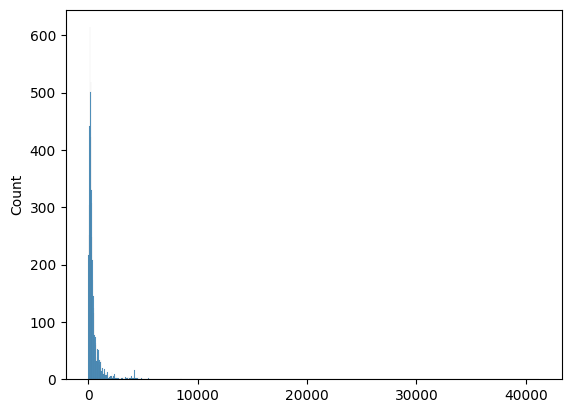

In [ ]:
# построим гистограмму для количества слов в отзывах
sns.histplot([len(x) for x in x_train_seq])

In [ ]:
# объявим функцию для чистки наших последовательностей от тега unknown
# мы предполагаем, что наличие тега unknown не несет значимой информации
def drop_UNKNOWN (x_seq, unknown=1):
    x_seq_short = []
    for x in x_seq:
        x_ = np.array(x)
        x_ = x_[np.where(x_ !=unknown )]
        x_seq_short.append(list(x_))
    return x_seq_short

In [ ]:
# очистим наши последовательности, полученные из обучающей и тестовой выборок
# от тега unknown с использованием объявленной функции
x_train_seq_short = drop_UNKNOWN(x_train_seq)
x_test_seq_short = drop_UNKNOWN(x_test_seq)

<Axes: ylabel='Count'>

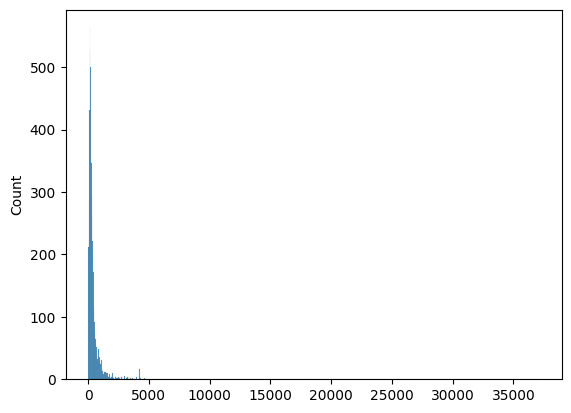

In [ ]:
# построим гистограмму количества токенов для последовательностей
# из которых был удален тег unknown
sns.histplot([len(x) for x in x_train_seq_short])

Анализируя графики мы делаем вывод, что большая часть наших отзывов имеет длинну последовательности токенов меньшую или равную 2000.

In [ ]:
# устанавливаем максимальную длинну последовательности токенов
MAX_LEN_SEQ = 2000

In [ ]:
# вырвниваем длинну всех последовательностей токенов до MAX_LEN_SEQ
# при помощи стандартного инструмента pad_sequence, входящего в Keras
# при этом последовательности короче MAX_LEN_SEQ будут дополнены нулями
# а последовательности длиннее MAX_LEN_SEQ будут обрезаны

x_train_emb = pad_sequences(x_train_seq_short, padding='post', maxlen=MAX_LEN_SEQ)
x_test_emb = pad_sequences(x_test_seq_short, padding='post', maxlen=MAX_LEN_SEQ)

In [ ]:
# объявляем кодировщик для целевого признака (класса отзыва)
# используем стандартный OneHotEncoder из библиотеки Sklearn
target_encoeder = OneHotEncoder(sparse=False)

# обучаем наш кодировщик на целевых призаках обучающей выборки
target_encoeder.fit(y_train_raw.reshape([-1, 1]))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(sparse=False, sparse_output=False)

In [ ]:
# объявляем переменную classes_names, в которой сохраним матрицу
# с названиями классов (тип отзыва)
# названия классов понадобятся нам на этапе инференса
classes_names = target_encoeder.categories_[0]
classes_names

array(['negative', 'neutral', 'positive'], dtype=object)

In [ ]:
# переведем целевые переменные для обучающей и тестовой выборки в формат OHE
# это нужно для подачи в модель

y_train_01 = target_encoeder.transform(y_train_raw.reshape([-1, 1]))
y_test_01 = target_encoeder.transform(y_test_raw.reshape([-1, 1]))

### Создание и обучение модели

In [ ]:
# объявим нашу модель
modelEmb = Sequential() # объявляем нашу модель как последовательность слоев
# добавляем слой Embedding
modelEmb.add(Embedding(input_dim=NUM_WORDS, output_dim=200, input_length=MAX_LEN_SEQ))
# добавляем слой SpatialDropout1D для "прореживания" и борьбы с переобучением
modelEmb.add(SpatialDropout1D(0.5))
# добавим выравнивающий слой
modelEmb.add(Flatten())
# добавим Dense слой на 16 нейронов
modelEmb.add(Dense(16,  activation='relu'))
# добавим батч-нормализацию для борьбы с переобучением
modelEmb.add(BatchNormalization())
# добавим прореживание для борьбы с переобучением
modelEmb.add(Dropout(0.2))
# добавим выходной полносвязный слой для классификации
modelEmb.add(Dense(n_classes,activation='softmax'))

# компилируем модель
modelEmb.compile(optimizer=Adam(learning_rate=0.001),  loss='categorical_crossentropy',  metrics=['accuracy'])

# выводим данные по модели
modelEmb.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 200)         4000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 2000, 200)        0         
 ropout1D)                                                       
                                                                 
 flatten (Flatten)           (None, 400000)            0         
                                                                 
 dense_2 (Dense)             (None, 16)                6400016   
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 16)               

In [ ]:
# обучаем модель
modelEmb.fit(x = x_train_emb,  y = y_train_01, epochs = 10, verbose = 1, validation_data= (x_test_emb, y_test_01))

Epoch 1/10
194/194 [==============================] - 23s 111ms/step - loss: 1.1553 - accuracy: 0.3797 - val_loss: 1.2262 - val_accuracy: 0.1912
Epoch 2/10
194/194 [==============================] - 21s 107ms/step - loss: 1.0161 - accuracy: 0.4597 - val_loss: 1.0501 - val_accuracy: 0.4429
Epoch 3/10
194/194 [==============================] - 21s 108ms/step - loss: 0.8389 - accuracy: 0.5871 - val_loss: 0.9330 - val_accuracy: 0.5426
Epoch 4/10
194/194 [==============================] - 21s 110ms/step - loss: 0.6133 - accuracy: 0.7455 - val_loss: 0.8036 - val_accuracy: 0.6317
Epoch 5/10
194/194 [==============================] - 21s 108ms/step - loss: 0.3997 - accuracy: 0.8662 - val_loss: 0.8064 - val_accuracy: 0.6738
Epoch 6/10
194/194 [==============================] - 21s 108ms/step - loss: 0.3287 - accuracy: 0.8946 - val_loss: 0.8379 - val_accuracy: 0.6825
Epoch 7/10
194/194 [==============================] - 21s 109ms/step - loss: 0.2364 - accuracy: 0.9303 - val_loss: 0.8486 - val_ac

### Инференс модели

In [ ]:
# создадим новый отзыв, по которому мы хотим получить предсказание
new_rewiew = """Вертолет Ми-8Т, принадлежащий компании "АлтайАвиа", потерпел крушение в районе села Тюнгур в Усть-Коксинском районе Республики Алтай примерно в 15:00 по местному времени (11:00 мск). По предварительным данным, при заходе на посадку машина задела электропровода и загорелась.
На борту находились 16 человек: трое членов экипажа и 13 туристов. Восемь человек доставили в больницу, из них четверо в тяжелом состоянии, еще у четверых травмы средней степени тяжести. Среди погибших — одна гражданка Белоруссии.
"""

In [ ]:
# выведем отзыв на печать
pprint(new_rewiew, width=PPRINT_WIDTH)

('Вертолет Ми-8Т, принадлежащий компании "АлтайАвиа", потерпел крушение в районе села Тюнгур в Усть-Коксинском районе Республики Алтай примерно в 15:00 по '
 'местному времени (11:00 мск). По предварительным данным, при заходе на посадку машина задела электропровода и загорелась.\n'
 'На борту находились 16 человек: трое членов экипажа и 13 туристов. Восемь человек доставили в больницу, из них четверо в тяжелом состоянии, еще у четверых '
 'травмы средней степени тяжести. Среди погибших — одна гражданка Белоруссии.\n')


In [ ]:
review_to_seq = tokenizer.texts_to_sequences([new_rewiew]) # преобразуем наш отзыв в последовательность индексов
review_to_seq = drop_UNKNOWN(review_to_seq) # удалим из отзыва тег UNKNOWN
review_to_emb = pad_sequences(review_to_seq, padding='post', maxlen=MAX_LEN_SEQ) # выравняем длинну наше последовательности до MAX_LEN_SEQ

In [ ]:
pred = modelEmb.predict(review_to_emb) # получим предсказание нашей модели в виде вероятностей по каждому классу
num_class = np.argmax(pred)  # получим номер наиболее вероятного класса

1/1 [==============================] - 0s 60ms/step


In [ ]:
num_class # посмотрим номер наиболее вероятного класса

0

In [ ]:
classes_names[num_class] # выведем название класса, предсказанного моделью

'negative'

# Дополнительные алгоритмы и продвинутые методы работы с текстами

Теперь, когда мы рассмотрели базовые алгоритмы подготовки текстов к подаче в нейронную сеть рассмотрим, какие еще существуют подходы и техники к работе с текстами.
Вы можете использовать их как по отдельности, так и в сочетании друг с другом и ранее изученными алгоритмами.

В данном разделе мы рассмотрим три базовые темы:
1. Превращение текста в списки слов (токенов)
2. Векторизация с использованием алгоритмов из библиотеки SKlearn
3. Word2Vec


Установим и импортируем библиотеки, которые нам понадобятся в этом разделе.

In [ ]:
!pip install -q pymorphy2 # установим библиотеку pymorphy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 21.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# импортируем специализированные библиотеки nltk, pymorphy2 и gensim
# это специализированные библиотеки для работы с естественным языком
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer

import pymorphy2

from gensim.models.word2vec import Word2Vec
from gensim.utils import simple_preprocess
import gensim.downloader as api

nltk.download('stopwords')
nltk.download('punkt')

# из библиотеки Sklearn импортируем три наиболее популярных Vectorizer для работы с текстами
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Токенизация, удаление стоп-слов

Первым этапом при работе с текстом является его токенизация, т.е. разбиение на составные части. При этом на первом этапе мы можем весь текст разбить на составные единицы - предложения, а предложения в свою очередь разбить на отдельные слова (токены)

Мы уже изучили Tokenizer, входящий в Keras.  Нужно также понимать, что Keras не является специализированным NLP-пакетом, и Keras Tokenizer имеет только базовый функционал. Посмотрим, как применять токенизацию на примере функций sent_tokenize и word_tokenize, входящих в состав библиотеки nltk.

Еще одной концепцией, которую нам нужно понять являются стоп-слова (stop-words). Основная мысль этой концепции заключается в том, что не все слова несут нашей модели полезную информацию. Такие слова как "и", "в", "на", "это", "по" и т.д. скорее будут мешать нашей модели находить что-то по настоящему полезное.
Нам будет полезно избавиться от этих слов на этапе предобработки. Мы воспользуемся готовым списком русских стоп-слов (stopwords из библиотеки nltk).

In [ ]:
# возьмем любой отзыв, на котором будем показывать технику работы с текстами
new_rewiew = """ Если вы еще не видели этот фильм, вам действительно стоит это сделать. Я не помню со времён 'Мертвеца ' и 'Дон Жуан де Марко ' ещё какую-то столь же яркую роль Деппа.
Знакомьтесь — Джон Уилмот граф Рочестер, поэт, драматург, сатирик, бунтарь, безбожник, распутник, любимец женщин, фаворит короля. Последнего, кстати, Карла II по прозвищу 'Весёлый король', уставшего уже от эпохи распуства и пытающегося внести хоть какой-то порядок в государственные дела, сына убитого Кромвелем Карла I, обладателя большого кривого носа превосходно сыграл Джон Малкович.
'Распутник' снят по реальным событиям. Сам по себе Джон Уилмот был личность незаурядная, яркая. Ещё при своей жизни он послужил прототипом персонажей для нескольких театральных пьес. Что уж говорить, что после смерти интерес к нему никак не ослабел. В 1994 году драматург Стивен Джефриз написал пьесу 'The Libertine', которая шла на сцене Лондонского Королевского Театра (с Джоном Малковичем в главной роли). В 2004 режиссёр Лоренс Данмор экранизирует пьесу Джефриза, тем самым увековечив удивительную жизнь графа Рочестера в кинематографе.
Жизнь и вправду была не скучная — похитил богатую невесту, отсидел в Тауре (правда недолго), воевал на флоте (где отличился), снова похитил невесту (на этот раз женился), писал стихи и пьесы (в том числе похабные, в том числе сатиры на короля), был отлучен от Двора (опять же не надолго), ну и, конечно, попойки, карты, женщины и... театр.
"""

In [ ]:
# при помощи функции sent_tokenize разобъем наш отзыв на отдельные предожения
ss = sent_tokenize(new_rewiew)

In [ ]:
len(ss) # посмотрим на количество получившихся предожений

11

In [ ]:
pprint(ss, width=PPRINT_WIDTH) # посмотрим на полученный список предложений

[' Если вы еще не видели этот фильм, вам действительно стоит это сделать.',
 "Я не помню со времён 'Мертвеца ' и 'Дон Жуан де Марко ' ещё какую-то столь же яркую роль Деппа.",
 'Знакомьтесь — Джон Уилмот граф Рочестер, поэт, драматург, сатирик, бунтарь, безбожник, распутник, любимец женщин, фаворит короля.',
 "Последнего, кстати, Карла II по прозвищу 'Весёлый король', уставшего уже от эпохи распуства и пытающегося внести хоть какой-то порядок в государственные "
 'дела, сына убитого Кромвелем Карла I, обладателя большого кривого носа превосходно сыграл Джон Малкович.',
 "'Распутник' снят по реальным событиям.",
 'Сам по себе Джон Уилмот был личность незаурядная, яркая.',
 'Ещё при своей жизни он послужил прототипом персонажей для нескольких театральных пьес.',
 'Что уж говорить, что после смерти интерес к нему никак не ослабел.',
 "В 1994 году драматург Стивен Джефриз написал пьесу 'The Libertine', которая шла на сцене Лондонского Королевского Театра (с Джоном Малковичем в главной "
 '

In [ ]:
# разобъем наш текст на слова с использованием word_tokenize из пакета nltk
tokens = word_tokenize(new_rewiew, language='russian')

In [ ]:
# выведем список получившихся слов (токенов) на печать
pprint(tokens, compact=True, width=PPRINT_WIDTH)

['Если', 'вы', 'еще', 'не', 'видели', 'этот', 'фильм', ',', 'вам', 'действительно', 'стоит', 'это', 'сделать', '.', 'Я', 'не', 'помню', 'со', 'времён',
 "'Мертвеца", "'", 'и', "'Дон", 'Жуан', 'де', 'Марко', "'", 'ещё', 'какую-то', 'столь', 'же', 'яркую', 'роль', 'Деппа', '.', 'Знакомьтесь', '—', 'Джон',
 'Уилмот', 'граф', 'Рочестер', ',', 'поэт', ',', 'драматург', ',', 'сатирик', ',', 'бунтарь', ',', 'безбожник', ',', 'распутник', ',', 'любимец', 'женщин', ',',
 'фаворит', 'короля', '.', 'Последнего', ',', 'кстати', ',', 'Карла', 'II', 'по', 'прозвищу', "'Весёлый", 'король', "'", ',', 'уставшего', 'уже', 'от', 'эпохи',
 'распуства', 'и', 'пытающегося', 'внести', 'хоть', 'какой-то', 'порядок', 'в', 'государственные', 'дела', ',', 'сына', 'убитого', 'Кромвелем', 'Карла', 'I',
 ',', 'обладателя', 'большого', 'кривого', 'носа', 'превосходно', 'сыграл', 'Джон', 'Малкович', '.', "'Распутник", "'", 'снят', 'по', 'реальным', 'событиям',
 '.', 'Сам', 'по', 'себе', 'Джон', 'Уилмот', 'был', 'личн

In [ ]:
# очистим наш список токенов от пунктуации и знаков препинания
tokens = [i for i in tokens if (i not in '!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~')]

In [ ]:
# посмотрим на результат
pprint(tokens, compact=True, width=PPRINT_WIDTH)

['Если', 'вы', 'еще', 'не', 'видели', 'этот', 'фильм', 'вам', 'действительно', 'стоит', 'это', 'сделать', 'Я', 'не', 'помню', 'со', 'времён', "'Мертвеца", 'и',
 "'Дон", 'Жуан', 'де', 'Марко', 'ещё', 'какую-то', 'столь', 'же', 'яркую', 'роль', 'Деппа', 'Знакомьтесь', '—', 'Джон', 'Уилмот', 'граф', 'Рочестер', 'поэт',
 'драматург', 'сатирик', 'бунтарь', 'безбожник', 'распутник', 'любимец', 'женщин', 'фаворит', 'короля', 'Последнего', 'кстати', 'Карла', 'II', 'по', 'прозвищу',
 "'Весёлый", 'король', 'уставшего', 'уже', 'от', 'эпохи', 'распуства', 'и', 'пытающегося', 'внести', 'хоть', 'какой-то', 'порядок', 'в', 'государственные',
 'дела', 'сына', 'убитого', 'Кромвелем', 'Карла', 'I', 'обладателя', 'большого', 'кривого', 'носа', 'превосходно', 'сыграл', 'Джон', 'Малкович', "'Распутник",
 'снят', 'по', 'реальным', 'событиям', 'Сам', 'по', 'себе', 'Джон', 'Уилмот', 'был', 'личность', 'незаурядная', 'яркая', 'Ещё', 'при', 'своей', 'жизни', 'он',
 'послужил', 'прототипом', 'персонажей', 'для',

In [ ]:
# приведем все наши токены (слова) к нижнему регистру
tokens = [i.lower() for i in tokens]
# посмотрим на результат
pprint(tokens, compact=True, width=PPRINT_WIDTH)

['если', 'вы', 'еще', 'не', 'видели', 'этот', 'фильм', 'вам', 'действительно', 'стоит', 'это', 'сделать', 'я', 'не', 'помню', 'со', 'времён', "'мертвеца", 'и',
 "'дон", 'жуан', 'де', 'марко', 'ещё', 'какую-то', 'столь', 'же', 'яркую', 'роль', 'деппа', 'знакомьтесь', '—', 'джон', 'уилмот', 'граф', 'рочестер', 'поэт',
 'драматург', 'сатирик', 'бунтарь', 'безбожник', 'распутник', 'любимец', 'женщин', 'фаворит', 'короля', 'последнего', 'кстати', 'карла', 'ii', 'по', 'прозвищу',
 "'весёлый", 'король', 'уставшего', 'уже', 'от', 'эпохи', 'распуства', 'и', 'пытающегося', 'внести', 'хоть', 'какой-то', 'порядок', 'в', 'государственные',
 'дела', 'сына', 'убитого', 'кромвелем', 'карла', 'i', 'обладателя', 'большого', 'кривого', 'носа', 'превосходно', 'сыграл', 'джон', 'малкович', "'распутник",
 'снят', 'по', 'реальным', 'событиям', 'сам', 'по', 'себе', 'джон', 'уилмот', 'был', 'личность', 'незаурядная', 'яркая', 'ещё', 'при', 'своей', 'жизни', 'он',
 'послужил', 'прототипом', 'персонажей', 'для',

In [ ]:
# загрузим список стоп-слов русского языка
stop_words = stopwords.words('russian')

# добавим в него еще немного стоп-слов
stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', '–', 'к', 'на', '...'])

# очистим наш список токенов от стоп-слов
tokens = [i for i in tokens if (i not in stop_words)]

In [ ]:
# посмотрим на результат
pprint(tokens, compact=True, width=PPRINT_WIDTH)

['видели', 'фильм', 'действительно', 'стоит', 'сделать', 'помню', 'времён', "'мертвеца", "'дон", 'жуан', 'де', 'марко', 'ещё', 'какую-то', 'столь', 'яркую',
 'роль', 'деппа', 'знакомьтесь', 'джон', 'уилмот', 'граф', 'рочестер', 'поэт', 'драматург', 'сатирик', 'бунтарь', 'безбожник', 'распутник', 'любимец', 'женщин',
 'фаворит', 'короля', 'последнего', 'кстати', 'карла', 'ii', 'прозвищу', "'весёлый", 'король', 'уставшего', 'эпохи', 'распуства', 'пытающегося', 'внести',
 'какой-то', 'порядок', 'государственные', 'дела', 'сына', 'убитого', 'кромвелем', 'карла', 'i', 'обладателя', 'большого', 'кривого', 'носа', 'превосходно',
 'сыграл', 'джон', 'малкович', "'распутник", 'снят', 'реальным', 'событиям', 'джон', 'уилмот', 'личность', 'незаурядная', 'яркая', 'ещё', 'своей', 'жизни',
 'послужил', 'прототипом', 'персонажей', 'нескольких', 'театральных', 'пьес', 'говорить', 'смерти', 'интерес', 'нему', 'никак', 'ослабел', '1994', 'году',
 'драматург', 'стивен', 'джефриз', 'написал', 'пьесу', "'th

In [ ]:
# почистим от кавычек, которые могли "прилипнуть" к словам
tokens = [i.replace("«", "").replace("»", "").replace("'", "").replace('"', "") for i in tokens]
pprint(tokens, compact=True, width=PPRINT_WIDTH)

['видели', 'фильм', 'действительно', 'стоит', 'сделать', 'помню', 'времён', 'мертвеца', 'дон', 'жуан', 'де', 'марко', 'ещё', 'какую-то', 'столь', 'яркую',
 'роль', 'деппа', 'знакомьтесь', 'джон', 'уилмот', 'граф', 'рочестер', 'поэт', 'драматург', 'сатирик', 'бунтарь', 'безбожник', 'распутник', 'любимец', 'женщин',
 'фаворит', 'короля', 'последнего', 'кстати', 'карла', 'ii', 'прозвищу', 'весёлый', 'король', 'уставшего', 'эпохи', 'распуства', 'пытающегося', 'внести',
 'какой-то', 'порядок', 'государственные', 'дела', 'сына', 'убитого', 'кромвелем', 'карла', 'i', 'обладателя', 'большого', 'кривого', 'носа', 'превосходно',
 'сыграл', 'джон', 'малкович', 'распутник', 'снят', 'реальным', 'событиям', 'джон', 'уилмот', 'личность', 'незаурядная', 'яркая', 'ещё', 'своей', 'жизни',
 'послужил', 'прототипом', 'персонажей', 'нескольких', 'театральных', 'пьес', 'говорить', 'смерти', 'интерес', 'нему', 'никак', 'ослабел', '1994', 'году',
 'драматург', 'стивен', 'джефриз', 'написал', 'пьесу', 'the', '

## Лемматизация и стемминг

Итак, мы разбили наши тексты на отдельны слова (токены).
Мы с вами знаем, что слова в русском языке очень изменчивы. Было бы классно подавать модели не все возможные словоформы, а каким-то образом привести разные варианты одного и того же слова к одному токену.
Для этого выделяют два основных подхода:
* Стемминг
* Лемматизация

**Стемминг** - это "стрижка" слов, когда по определенному алгоритму удаляются окончания.

**Лемматизация** - приведение слова к начальной форме с использованием готовых словарей.

In [ ]:
# создаем объект "стеммер" используя SnowballStemmer из библиотеки nltk
snowball = SnowballStemmer(language='russian')

In [ ]:
# делаем "стрижку" наших токенов
tokens_stemmed = [snowball.stem(i.lower()) for i in tokens]

# и смотрим, что у нас получилось
pprint(tokens_stemmed, compact=True, width=PPRINT_WIDTH)

['видел', 'фильм', 'действительн', 'сто', 'сдела', 'помн', 'врем', 'мертвец', 'дон', 'жуа', 'де', 'марк', 'ещ', 'какую-т', 'стол', 'ярк', 'рол', 'депп',
 'знакомьт', 'джон', 'уилмот', 'граф', 'рочестер', 'поэт', 'драматург', 'сатирик', 'бунтар', 'безбожник', 'распутник', 'любимец', 'женщин', 'фавор', 'корол',
 'последн', 'кстат', 'карл', 'ii', 'прозвищ', 'весел', 'корол', 'уста', 'эпох', 'распуств', 'пыта', 'внест', 'какой-т', 'порядок', 'государствен', 'дел', 'сын',
 'убит', 'кромвел', 'карл', 'i', 'обладател', 'больш', 'крив', 'нос', 'превосходн', 'сыгра', 'джон', 'малкович', 'распутник', 'снят', 'реальн', 'событ', 'джон',
 'уилмот', 'личност', 'незаурядн', 'ярк', 'ещ', 'сво', 'жизн', 'послуж', 'прототип', 'персонаж', 'нескольк', 'театральн', 'пьес', 'говор', 'смерт', 'интерес',
 'нем', 'никак', 'ослабел', '1994', 'год', 'драматург', 'стив', 'джефриз', 'написа', 'пьес', 'the', 'libertine', 'котор', 'шла', 'сцен', 'лондонск',
 'королевск', 'театр', 'джон', 'малкович', 'главн', 'рол', 

In [ ]:
# создадим объект Лемматизатор, используя функцию MorphAnalyzer из пакета pymorphy2
morph = pymorphy2.MorphAnalyzer()

# посмотрим на результат работы лемматизатора на примере одного слова
morph.parse("хочу")

[Parse(word='хочу', tag=OpencorporaTag('VERB,impf,tran sing,1per,pres,indc'), normal_form='хотеть', score=1.0, methods_stack=((DictionaryAnalyzer(), 'хочу', 3136, 1),))]

In [ ]:
# а вот так можно "дотянуться" до начальной формы произвольного слова
morph.parse("хотеть")[0].normal_form

'хотеть'

In [ ]:
# лемматизируем все наши токены
tokens_lemmatized = [morph.parse(i)[0].normal_form for i in tokens]

In [ ]:
# посмотрим на результат
pprint(tokens_lemmatized, compact=True, width=PPRINT_WIDTH)

['видеть', 'фильм', 'действительно', 'стоить', 'сделать', 'помнить', 'время', 'мертвец', 'дон', 'жуан', 'де', 'марко', 'ещё', 'какой-то', 'столь', 'яркий',
 'роль', 'деппа', 'знакомиться', 'джон', 'уилмота', 'граф', 'рочестер', 'поэт', 'драматург', 'сатирик', 'бунтарь', 'безбожник', 'распутник', 'любимец',
 'женщина', 'фаворит', 'король', 'последний', 'кстати', 'карла', 'ii', 'прозвище', 'весёлый', 'король', 'устать', 'эпоха', 'распуство', 'пытаться', 'внести',
 'какой-то', 'порядок', 'государственный', 'дело', 'сын', 'убитый', 'кромвель', 'карла', 'i', 'обладатель', 'большой', 'кривой', 'нос', 'превосходно',
 'сыграть', 'джон', 'малкович', 'распутник', 'снятой', 'реальный', 'событие', 'джон', 'уилмота', 'личность', 'незаурядный', 'яркий', 'ещё', 'свой', 'жизнь',
 'послужить', 'прототип', 'персонаж', 'несколько', 'театральный', 'пьеса', 'говорить', 'смерть', 'интерес', 'он', 'никак', 'ослабеть', '1994', 'год',
 'драматург', 'стивен', 'джефриз', 'написать', 'пьеса', 'the', 'libertine', 

## Соединим всё вместе

In [ ]:
# создадим функцию, предобрабатывающую текст на русском языке
def preprocess_russian(text):
    '''
    функция принимает на вход текст
    очищает от знков препинания и стоп слов
    и возвращает список слов в начальной форме
    '''
    tokens = nltk.word_tokenize(text, language='russian') # разбиваем текст на токены

    # чистим от мусора, ковычек и приводим к нижнему регистру
    tokens = [i for i in tokens if (i not in '!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~')]
    tokens = [i.replace("«", "").replace("»", "").replace("'", "").replace('"', "") for i in tokens]
    tokens = [i.lower() for i in tokens]

    # загружаем стоп-слова из nltk и добавляем свои
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', '–', 'к', 'на', '...'])
    # удаляем стоп-слова
    tokens = [i for i in tokens if (i not in stop_words)] # удаляем стоп-слова из спика слов
    # берем начальную словоформу с помощью лемматизатора
    tokens_lemmatized = [morph.parse(i)[0].normal_form for i in tokens]

    return tokens_lemmatized

In [ ]:
# преобразуем наш текст в набор токенов
x_train_tokens = [preprocess_russian(text) for text in x_train_raw]

In [ ]:
# посмотрим во что преобразовался первый отзыв
pprint(x_train_tokens[0], compact=True, width=PPRINT_WIDTH)

['сегодня', 'председательство', 'заместитель', 'премьер-министр', 'рк', 'имангали', 'тасмагамбетов', 'состояться', 'селекторный', 'совещание', 'вопрос',
 'оказание', 'содействие', 'корпоративный', 'фонд', '``', 'sos', 'детский', 'деревня', 'казахстан', '', 'ссылка', 'официальный', 'сайт', 'премьер-министр',
 'рк', 'работа', 'совещание', 'принять', 'участие', 'председатель', 'попечительский', 'совет', 'корпоративный', 'фонд', '``', 'sos', 'детский', 'деревня',
 'казахстан', '', 'серик', 'сейдуманов', 'заместитель', 'аким', 'город', 'алматы', 'астана', 'карагандинский', 'область', 'год', '``', 'sos', 'детский',
 'деревня', 'казахстан', '', 'исполняться', '20', 'год', 'впервые', 'алматы', 'приёмный', 'семья', 'появиться', '90-й', 'год', 'год', '``', 'sos', 'детский',
 'деревня', 'город', 'темиртау', '', 'достигнуть', '100-процентный', 'финансирование', 'содержание', 'детея-сирота', 'ребёнок', 'остаться', 'попечение',
 'родитель', 'аналогичный', 'финансирование', 'алматинский', 'детский', 

In [ ]:
# соединим наши слова (токены) в одну строку
x_train_texts = [' '.join(tokens) for tokens in x_train_tokens]

In [ ]:
# выведем полученную строку на печать
pprint(x_train_texts[0], compact=True, width=PPRINT_WIDTH)

('сегодня председательство заместитель премьер-министр рк имангали тасмагамбетов состояться селекторный совещание вопрос оказание содействие корпоративный '
 'фонд `` sos детский деревня казахстан  ссылка официальный сайт премьер-министр рк работа совещание принять участие председатель попечительский совет '
 'корпоративный фонд `` sos детский деревня казахстан  серик сейдуманов заместитель аким город алматы астана карагандинский область год `` sos детский деревня '
 'казахстан  исполняться 20 год впервые алматы приёмный семья появиться 90-й год год `` sos детский деревня город темиртау  достигнуть 100-процентный '
 'финансирование содержание детея-сирота ребёнок остаться попечение родитель аналогичный финансирование алматинский детский деревня акимат считать необходимый '
 'изменение форма собственность вопрос финансирование содержание детея-сирота ребёнок остаться попечение родитель `` sos детский деревня  подниматься ранее '
 'результат 2015 год местный исполнительный орган рекоменд

## Векторизация

В данном разделе мы рассмотрим три варианта, дополняющие подход OHE кодирования.
Все варианты могут быть реализованы с помощью стандартных функций из библиотеки Sklearn

### CountVectorizer

CountVectorizer похож на подход OHE, но он возвращает не 0/1, а считает количество вхождений для каждого слова.

In [ ]:
# объявим наш vectorizer, обратите внимание на возможность использовать stop-words
vectorizer = CountVectorizer(max_features=2000, stop_words=stop_words)

In [ ]:
# обучим CountVectorizer на наших текстах
vectorizer.fit(x_train_raw)

CountVectorizer(max_features=2000,
                stop_words=['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с',
                            'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его',
                            'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы',
                            'по', 'только', 'ее', 'мне', ...])

In [ ]:
# преобразуем наши тексты в векторную форму
x_train_count = vectorizer.transform(x_train_raw).toarray()
x_test_count = vectorizer.transform(x_test_raw).toarray()

In [ ]:
# посмотрим на размерной полученной матрицы
x_train_count.shape

(6197, 2000)

In [ ]:
# посмотрим на вектор, являющийся первой строкой полученной матрицы
x_train_count[0]

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# посмотрим на максимальный элемент вектра
x_train_count[0].max()

9

### TfidfVectorizer

Одна из проблем CountVectorizer является то, что некоторые слова, которые часто встречаются в тексте могут оказаться не очень важными. Этого недостатка лишен TfidfVectorizer. Для каждого слова в наборе (корпусе) документов он рассчитвает метрику, зависящую от двух факторов:
* **Частота слова (Term Frequency)** - предполагаем что слово, которое часто встречается в документе, важно этого документа.
* **Обратная частота документа (Inverse Document Frequency)**  - предполагаем, что слово, которое часто встречается во всех документах менее важно для конкретного документа.

Знакомиться со сложными математическими формулами мы не будем, достаточно знать основной принцип работы TfidfVectorizer.

In [ ]:
# создадим функцию, с помощью которой мы склеим между собой отзывы с одинаковой оценкой
# эти огромные тексты пригодятся нам для обучения нашего TfidfVectorizer
def join_texts (X_train, y_train):

    train_data = pd.DataFrame({'text': X_train, 'label': y_train})

    joined_texts = []
    classes = []
    for label in train_data.label.unique():
        joined_text = list(train_data[train_data.label == label]['text'])
        joined_texts.append(' '.join(joined_text))
        classes.append(label)
    return joined_texts

joined_text = join_texts(x_train_raw, y_train_raw)

In [ ]:
# объявим наш TfidfVectorizer и обучим его на полученных текстах
vectorizer = TfidfVectorizer(max_features = 20000)
vectorizer.fit(joined_text)

TfidfVectorizer(max_features=20000)

In [ ]:
# с помощью обученного vectorizer преобразуем наши обучающие выборки в векторную форму
x_train_tfidf = vectorizer.transform(x_train_raw).toarray()
x_test_tfidf = vectorizer.transform(x_test_raw).toarray()

In [ ]:
# посмотрим на размерность матрицы
x_train_tfidf.shape

(6197, 20000)

In [ ]:
# и на одну из строк полученной матрицы
x_train_tfidf[0]

array([0., 0., 0., ..., 0., 0., 0.])

### HashingVectorizer

Подсчеты количества и частоты слов могут стать очень утомительными, а при росте количества слов растет словарь, что приводит замедлению алгоритмов и ограничениям на память.
**HashingVectorizer** помогает нам с этим бороться.  В его основе лежит простая идея - давайте сделаем одностороннюю функцию, которая с помощью функции (называется хэш-функция) преобразует слово в целое число из определенного диапазона.
* К недостаткам такого подхода можно отнести возникновение **коллизий** ситуаций, когда разные слова могут иметь одинаковое значение хэш функции.
* К плюсам же стоит отнести отутствие необходимости обучения HashingVectorizer (он сразу готов к работе) и его способность работать с любыми словами (не нужно контролировать, есть ли слово в словаре).

Кстати, подход, основанный на использовании Hashing Trick есть и в Keras. Вот [ссылка](https://tf.keras.layers.experimental.preprocessing.Hashing) на слой Hashing, который недавно появился в Keras.

In [ ]:
HASH_DIM = 1024 # установим размерность нашего пространства

# создадим наш Hashing vectorizer
vectorizer = HashingVectorizer(n_features=HASH_DIM)

In [ ]:
# преобразуем наши тексты в матрицы с помощью HashingVectorizer
x_train_hashed = vectorizer.transform(x_train_raw).toarray()
x_test_hashed = vectorizer.transform(x_test_raw).toarray()

In [ ]:
x_train_hashed.shape # посмотрим на размерности полученной матрицы

(6197, 1024)

In [ ]:
x_train_hashed[0] # посмотрим на произвольный вектор

array([0., 0., 0., ..., 0., 0., 0.])

# Word2Vec

Когда мы говорили про Embedding, то обусуждали концепцию векторного представления для слов, когда каждому слову мы сопоставлям вектор в 100 (200, 300) мерном пространстве. И говорили о том, что в обученном Embedding представлении схожие по смыслу слова имеют "близкие" вектора.

Word2Vec работает точно также. Основная разница в том, что Embedding слой обучается вместе с моделью, а представление Word2Vec можно обучить отдельно,  просто на текстах.

Для обучения Word2Vec  используется следующий алгоритм:
1. Скользящим окном текст нарезается на небольшие отрывыки (3-5 слов)
2. Обучается модель, которая по для каждого слова учится предсказывать слова, которые часто встречаются рядом, т.е.  в рамках одного отрывка.
3. Наш Word2Vec получается путем извлечения внутренних слоев из обученной таким образом модели.

Прямо сейчс нам не нужно понимать всех деталей обучения Word2Vec, мы просто можем взять готовые функции из библиотек. Важно понимать, что учить Word2Vec достаточно просто, ведь нам не нужно собирать и размечать данные. Достаточно найти большой корпус документов и иметь достаточно машинных ресурсов и терпения.

Отчасти понять для себя смысл векторизации можно на следующей картинке:

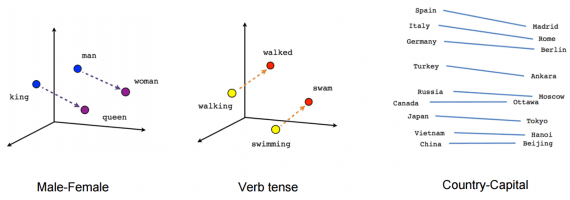

##Интересные особенности векторного представления

###Работа с векторами смыслов

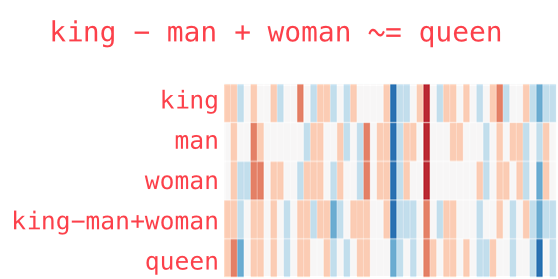

###Применение косинусного расстояния

Оно же коэффициент Отиаи, и рассчитывается как косинус угла между двумя векторами. При этом для параллельных (одинаково направленных) векторов $cos~0^o = 1$, $cos~90^o = 0$, а остальные значения для острых углов находятся где-то в промежутке между этими числами, для тупых углов - отрицательны. То есть можно использовать это для оценки схожести смыслов.

## Обучение представления Word2Vec под собственную задачу

В этом разделе мы посмотрим, как можно попробовать обучить представление Word2Vec под свою задачу. Для этого мы возьмем расширенную базу отзывов, чтобы получить более совершенное представление.

In [ ]:
df = text_data.copy()

In [ ]:
df.head()

,text,sentiment
0,Досудебное расследование по факту покупки ЕНПФ...,negative
1,Медики рассказали о состоянии пострадавшего му...,negative
2,"Прошел почти год, как железнодорожным оператор...",negative
3,По итогам 12 месяцев 2016 года на территории р...,negative
4,Астана. 21 ноября. Kazakhstan Today - Агентств...,negative


In [ ]:
# создадим функцию для предобработки текстов
# она похоже на ту, что мы уже использовали,
# но сейчас мы не будем использовть лемматизацию
def simple_preprocess_russian(text):
    tokens = nltk.word_tokenize(text, language='russian')
    tokens = [i for i in tokens if (i not in '!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~')]
    tokens = [i.replace("«", "").replace("»", "").replace("'", "").replace('"', "").replace('.', "") for i in tokens]
    tokens = [i.lower() for i in tokens]
    return tokens

In [ ]:
# Разобъем наш набор текстов на токены, для этого:
words = [] # создадим пустой список, в него будем добавлять списки слов
for review in df['text']: # проходим циклом по отзывам из нашего DataFrame
    ss = nltk.sent_tokenize(review,language="russian") # разбиваем отзывы на отдельные преложения
    for s in ss: # и для каждого предложения
        words.append(simple_preprocess_russian(s)) #извлекаем из него слова-токены

In [ ]:
len(words) # посмотрим на длину полученного списка (соответвтует количеству предожений)

234975

In [ ]:
pprint(words[0], compact=True) # выведем на печать какую-нибудь из записей в нашем списке

['досудебное', 'расследование', 'по', 'факту', 'покупки', 'енпф', 'пакета',
 'облигаций', 'тоо', '``', 'бузгул', 'аурум', '', 'было', 'начато', 'по',
 'инициативе', 'национального', 'банка', 'рк', 'сообщил', 'директор',
 'департамента', 'защиты', 'прав', 'потребителей', 'и', 'финансовых', 'услуг',
 'нацбанка', 'казахстана', 'александр', 'терентьев']


In [ ]:
# гиперпараметры для обучения Word2Vec
num_features = 100 #размность векторного пространства, в который будем переводить слова
min_word_count = 1 # сколько раз слово должно встретиться в текстах, что-бы мы брали его в расчет
num_workers = 4
window_size = 4 # размер окна, из которого мы формируем контекст
subsampling = 1e-3

w2v_my = Word2Vec(
       words,
       workers=num_workers,
       #size = num_features,
       min_count=min_word_count,
       window = window_size,
       sample=subsampling)

w2v_my.init_sims(replace=True) # выполняется для очистки памяти, удаляет лишние данные модели, использовать только если не планируете дообучать

# сохраним нашу модель
w2v_my.save("/content/my_w2vmodel")
w2v_my.wv.save_word2vec_format("/content/my_w2vmodel.w2v")

<ipython-input-113-5efece7d8c95>:16: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_my.init_sims(replace=True) # выполняется для очистки памяти, удаляет лишние данные модели, использовать только если не планируете дообучать


In [ ]:
# прочитаем сохраненную модель
w2v_my = Word2Vec.load("/content/my_w2vmodel")

In [ ]:
# вычислим, на что похоже "король" + "женщина" - "мужчина"
print(w2v_my.wv.most_similar(positive= ["президент", "женщина"], negative=["мужчина"]))

[('лидер', 0.673546552658081), ('абишевич', 0.6191481947898865), ('нназарбаев', 0.602411150932312), ('ушукеев', 0.600702166557312), ('банкиру', 0.5979880690574646), ('сосковец', 0.5965156555175781), ('премьер-министр', 0.5936344861984253), ('дюсенбаев', 0.5912243127822876), ('спикер', 0.5901100039482117), ('алферов', 0.5890763998031616)]


In [ ]:
# найдем близкие слова к слову "криминальный"
print(w2v_my.wv.most_similar(positive= ["криминальный"]))

[('дуэт', 0.9039736986160278), ('звук', 0.9035681486129761), ('замечательный', 0.9023818969726562), ('физикой', 0.9000256061553955), ('редкий', 0.899235725402832), ('семейный', 0.8982750177383423), ('is', 0.897822380065918), ('ненадолго', 0.8969886302947998), ('1,8-литровый', 0.8966189026832581), ('демонов', 0.896025538444519)]


In [ ]:
# найдем близкие слова к слову "траволта"
print(w2v_my.wv.most_similar(positive= ["путин"]))

[('владимир', 0.8746525049209595), ('нназарбаев', 0.8447821140289307), ('аблай', 0.8331830501556396), ('идрисов', 0.8318830728530884), ('жумаканов', 0.8314098119735718), ('лукашенко', 0.8293439745903015), ('уважаемый', 0.8197696208953857), ('франсис', 0.8154833316802979), ('медведев', 0.8118743896484375), ('мырзахметов', 0.8109391927719116)]


In [ ]:
w2v_my.wv['лидер'] # посмотрим, что из себя представляет векторное представление слова "лидер"

array([ 0.03451887,  0.07169258,  0.01476286,  0.10683554,  0.06532189,
       -0.18895815,  0.02202986, -0.05315551, -0.01328865, -0.17785731,
       -0.07545801, -0.06483399,  0.06748799,  0.08082946,  0.02406744,
       -0.1315665 ,  0.13768573, -0.0987053 , -0.08064941, -0.14237455,
        0.09033551,  0.08484629,  0.10119978,  0.08778019, -0.12297047,
       -0.04461596, -0.11089852,  0.1575129 ,  0.09808819,  0.03422377,
        0.1342123 ,  0.11978383, -0.10562769, -0.04297866, -0.13230474,
       -0.01009603,  0.1741815 ,  0.01415852, -0.00622775, -0.01654411,
       -0.17014362, -0.06601617, -0.19315237, -0.07507751,  0.04712859,
        0.06551532,  0.0424793 ,  0.10648251,  0.14866224,  0.12211551,
        0.03659914, -0.12823698, -0.15229866,  0.01363432, -0.10141366,
        0.05778472,  0.04368078, -0.08413007, -0.08265346,  0.29147768,
        0.00544773, -0.01675541,  0.06303609, -0.08815382, -0.06694683,
       -0.00155512, -0.1802568 , -0.01171706,  0.06955648,  0.09

## Загрузка предобученных Word2Vec представлений

Итак, мы научились обучать и сохранять собственные представления. Но самое удобное для нас заключается в том, что очень много представлений **Word2Vec** уже обучены до нас и мы просто можем воспользоваться готовыми.
Покажем, как загружать готовые представления на примере **gensim.downloader**.

In [ ]:
list(api.info()['models'].keys()) #выведем список представлений, доступных для скачивания

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

In [ ]:
# загрузим предобученные представления для русского и английского языков
w2v_ru = api.load("word2vec-ruscorpora-300")
w2v_en = api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 198.8/198.8MB downloaded
[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
# проверим, чему равно король + женщина - мужчина
print(w2v_ru.most_similar(positive= ["король_NOUN", "женщина_NOUN"], negative=["мужчина_NOUN"]))

[('королева_NOUN', 0.7313904762268066), ('герцог_NOUN', 0.6502388715744019), ('принцесса_NOUN', 0.6266285181045532), ('герцогиня_NOUN', 0.6240381598472595), ('королевство_NOUN', 0.6094207167625427), ('зюдерманландский_ADJ', 0.6084389686584473), ('дурлахский_ADJ', 0.608166515827179), ('ульрик::элеонора_NOUN', 0.6073107123374939), ('максимилианов_NOUN', 0.6057004332542419), ('принц_NOUN', 0.5984029173851013)]


In [ ]:
# проверим чему равно king + woman - man
print(w2v_en.most_similar(positive= ["king", "woman"], negative=["man"]))

[('queen', 0.6713277101516724), ('princess', 0.5432624816894531), ('throne', 0.5386103987693787), ('monarch', 0.5347574949264526), ('daughter', 0.49802514910697937), ('mother', 0.49564430117607117), ('elizabeth', 0.4832652509212494), ('kingdom', 0.47747090458869934), ('prince', 0.4668239951133728), ('wife', 0.46473270654678345)]


## Использование обученного представления Word2Vec в качестве Embedding слоя в Keras


Итак, мы имеем обученный Word2Vec. Как его использовать? Конечно, можно перевести наши слова в векторную форму и подавать их в модель. Но существует еще один способ - загрузить веса обученного Word2Vec в наш Enbedding слой.
Посмотрим, как это можно сделать.

In [ ]:
# произведем предобработку наших текстов
x_train_cleared = [' '.join(simple_preprocess_russian(text)) for text in x_train_raw]
x_test_cleared = [' '.join(simple_preprocess_russian(text)) for text in x_test_raw]

In [ ]:
NUM_WORDS = 20000 # максимальное количество слов
MAX_LEN_SEQ = 800 # длинна последовательности

# создадим tokenizer
tokenizer = Tokenizer(num_words=NUM_WORDS, # максимальное количество слов, которые будет учитывать наш токенайзер
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', # символы, которые он токенайзер будет фильтровать
                      lower=True,  #приводятся ли все символы к нижнему регситру
                      split=' ',  # символ, по которому происходит разделение на слова (токены)
                      char_level=False,  # являются ли токенами отдельные буквы
                      oov_token='UNKNOWN' # токен для неизвестных слов
                     )

# обучим токенайзер на обучающей выборке
tokenizer.fit_on_texts(x_train_cleared)

In [ ]:
# переведем наши тексты в последовательности
x_train_seq = tokenizer.texts_to_sequences(x_train_cleared)
x_test_seq = tokenizer.texts_to_sequences(x_test_cleared)
pprint(x_train_seq[0], compact=True)

In [ ]:
# выравняем длины последовательностей
x_train_emb = pad_sequences(x_train_seq, padding='post', maxlen=MAX_LEN_SEQ)
x_test_emb = pad_sequences(x_test_seq, padding='post', maxlen=MAX_LEN_SEQ)

In [ ]:
# объявим функцию для извлечения весов для Embedding из предобученного Word2Vec
def get_weight_matrix(embedding, vocab):
    # определим размер словаря
    vocab_size = NUM_WORDS+2
    # создадим матрицу нужной размерности
    weight_matrix = np.zeros((vocab_size, num_features))
    # проходим по словарю и сохраняем вектора, используя индексы из Tokenizer
    for word, i in vocab.items():
        if i <= vocab_size:
            try:
                weight_matrix[i] = embedding[word]
            except:
                print(f'word {word} not in vocabulary')
    return weight_matrix

embedding_vectors = get_weight_matrix(w2v_my, tokenizer.word_index)

Выходные данные были обрезаны до нескольких последних строк (5000).
word приложений not in vocabulary
word профессиональная not in vocabulary
word центральными not in vocabulary
word q400 not in vocabulary
word kселл not in vocabulary
word раскрыл not in vocabulary
word учредителей not in vocabulary
word автономной not in vocabulary
word сознание not in vocabulary
word арка not in vocabulary
word покупателю not in vocabulary
word аналогичной not in vocabulary
word письменного not in vocabulary
word дальнейший not in vocabulary
word человеческих not in vocabulary
word занимаемся not in vocabulary
word 285 not in vocabulary
word практическая not in vocabulary
word порогов not in vocabulary
word батареи not in vocabulary
word молодежью not in vocabulary
word почетную not in vocabulary
word ветеринарной not in vocabulary
word матыцин not in vocabulary
word мотор not in vocabulary
word привезти not in vocabulary
word графики not in vocabulary
word зонам not in vocabulary
word повторить not 

In [ ]:
# создаем нашу модель
modelEmb = Sequential()
# добавляем Embedding слой, в котором в качестве весов используются даные из предобученного Word2Vec
my_emb = Embedding(NUM_WORDS+2, 100, weights=[embedding_vectors], input_length=MAX_LEN_SEQ, trainable=True)
modelEmb.add(my_emb)

# добавляем слой SpatialDropout1D для "прореживания" и борьбы с переобучением
modelEmb.add(SpatialDropout1D(0.5))
# добавим выравнивающий слой
modelEmb.add(Flatten())
# добавим Dense слой на 16 нейронов
modelEmb.add(Dense(16,  activation='relu'))
# добавим батч-нормализацию для борьбы с переобучением
modelEmb.add(BatchNormalization())
# добавим прореживание для борьбы с переобучением
modelEmb.add(Dropout(0.2))
# добавим выходной полносвязный слой для классификации
modelEmb.add(Dense(n_classes,activation='softmax'))

# компилируем модель
modelEmb.compile(optimizer=Adam(learning_rate=0.001),  loss='categorical_crossentropy',  metrics=['accuracy'])

# выводим данные по модели
modelEmb.summary()

In [ ]:
# обучаем нашу модель
modelEmb.fit(x = x_train_emb,  y = y_train_01, epochs = 10, verbose = 1, validation_data= (x_test_emb, y_test_01))

Epoch 1/10
194/194 [==============================] - 7s 32ms/step - loss: 1.0400 - accuracy: 0.4856 - val_loss: 1.0209 - val_accuracy: 0.4884
Epoch 2/10
194/194 [==============================] - 6s 31ms/step - loss: 1.0226 - accuracy: 0.4881 - val_loss: 1.0205 - val_accuracy: 0.4884
Epoch 3/10
194/194 [==============================] - 6s 29ms/step - loss: 1.0225 - accuracy: 0.4881 - val_loss: 1.0205 - val_accuracy: 0.4884
Epoch 4/10
194/194 [==============================] - 6s 30ms/step - loss: 1.0223 - accuracy: 0.4881 - val_loss: 1.0204 - val_accuracy: 0.4884
Epoch 5/10
194/194 [==============================] - 6s 30ms/step - loss: 1.0220 - accuracy: 0.4881 - val_loss: 1.0205 - val_accuracy: 0.4884
Epoch 6/10
194/194 [==============================] - 6s 31ms/step - loss: 1.0221 - accuracy: 0.4881 - val_loss: 1.0204 - val_accuracy: 0.4884
Epoch 7/10
194/194 [==============================] - 6s 30ms/step - loss: 1.0222 - accuracy: 0.4881 - val_loss: 1.0207 - val_accuracy: 0.4884

#3.4.4 Использование BERT для построения эмбеддинга слов, классификации

In [ ]:
!gdown https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.1/lenta-ru-news.csv.bz2
!gdown http://files.deeppavlov.ai/deeppavlov_data/bert/rubert_cased_L-12_H-768_A-12_pt.tar.gz
!bzip2 -d lenta-ru-news.csv.bz2
!tar -xzf /content/rubert_cased_L-12_H-768_A-12_pt.tar.gz

Downloading...
From: https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.1/lenta-ru-news.csv.bz2
To: /content/Lenta.Ru-News-Dataset/lenta-ru-news.csv.bz2
100% 346M/346M [00:01<00:00, 179MB/s]
Downloading...
From: http://files.deeppavlov.ai/deeppavlov_data/bert/rubert_cased_L-12_H-768_A-12_pt.tar.gz
To: /content/Lenta.Ru-News-Dataset/rubert_cased_L-12_H-768_A-12_pt.tar.gz
100% 662M/662M [00:26<00:00, 25.3MB/s]


In [ ]:
!pip install transformers
!pip install pyyaml

In [ ]:
import gc
import numpy as np
import pandas as pd
import torch
import os
import json

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer

In [ ]:
gc.collect()
df = pd.read_csv('/content/Lenta.Ru-News-Dataset/lenta-ru-news.csv', low_memory=False)
df['topic'].unique()
# 'Библиотека', 'Россия', 'Мир', 'Экономика', 'Интернет и СМИ',
# 'Спорт', 'Культура', 'Из жизни', 'Силовые структуры',
# 'Наука и техника', 'Бывший СССР', nan, 'Дом', 'Сочи', 'ЧМ-2014',
# 'Путешествия', 'Ценности', 'Легпром', 'Бизнес', 'МедНовости',
# 'Оружие', '69-я параллель', 'Культпросвет ', 'Крым'

array(['Библиотека', 'Россия', 'Мир', 'Экономика', 'Интернет и СМИ',
       'Спорт', 'Культура', 'Из жизни', 'Силовые структуры',
       'Наука и техника', 'Бывший СССР', nan, 'Дом', 'Сочи', 'ЧМ-2014',
       'Путешествия', 'Ценности', 'Легпром', 'Бизнес', 'МедНовости',
       'Оружие', '69-я параллель', 'Культпросвет ', 'Крым'], dtype=object)

In [ ]:
corpus = df.loc[df['topic']=='Наука и техника', 'text'].to_numpy()
corpus = corpus[:10000]

In [ ]:
corpus[0]
# Американские ученые в ближайшее время отправят на орбиту спутник,
# который проверит два фундаментальных предположения, выдвинутых Альбертом Эйнштейном...

'Американские ученые в ближайшее время отправят на орбиту спутник, который проверит два фундаментальных предположения, выдвинутых Альбертом Эйнштейном в рамках общей теории относительности, сообщает Associated Press. Представители NASA и Стенфордского университета в пятницу рассказали о том, что проект спутника Gravity Probe B разрабатывается с 1959 года. С тех пор было проведено несколько неудачных попыток старта и решено множество технических проблем. Наконец, 17 апреля спутник будет запущен с базы ВВС США Вандерберг. Аппарат создан с тем, чтобы проверить высказанные в теории относительности Альберта Эйнштейна предположения относительно пространственно-временных закономерностей любых физических процессов. Эксперимент касается заявления ученого о том, что пространство и время искривляются в присутствии Земли, а вращение Земли "увлекает за собой" пространство и время. В основе аппарата - четыре кварцевых сферы размером с мяч для пинг-понга. Шары находятся в гироскопах и максимально изо

In [ ]:
with open("/content/rubert_cased_L-12_H-768_A-12_pt/bert_config.json", "r") as read_file, open("/content/rubert_cased_L-12_H-768_A-12_pt/config.json", "w") as conf:
    file = json.load(read_file)
    conf.write(json.dumps(file))

In [ ]:
!rm /content/rubert_cased_L-12_H-768_A-12_pt/bert_config.json

In [ ]:
#tokenizer = BertTokenizer.from_pretrained('rubert_cased_L-12_H-768_A-12_pt')
#model = BertModel.from_pretrained('rubert_cased_L-12_H-768_A-12_pt', output_hidden_states = True)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
model = BertModel.from_pretrained('DeepPavlov/rubert-base-cased', output_hidden_states = True)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class CustomDataset(Dataset):

    def __init__(self, X):
        self.text = X

    def tokenize(self, text):
        return tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=150)

    def __len__(self):
        return self.text.shape[0]

    def __getitem__(self, index):
        output = self.text[index]
        output = self.tokenize(output)
        return {k: v.reshape(-1) for k, v in output.items()}


eval_ds = CustomDataset(corpus)
eval_dataloader = DataLoader(eval_ds, batch_size=10)

In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output['last_hidden_state']
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
model.eval()

embeddings = torch.Tensor().to(device)

with torch.no_grad():
    for n_batch, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        embeddings = torch.cat([embeddings, mean_pooling(outputs, batch['attention_mask'])])
    embeddings = embeddings.cpu().numpy()

100%|██████████| 1000/1000 [44:00<00:00,  2.64s/it]


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15, random_state=42)
emb_15d = pca.fit_transform(embeddings)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0.6, affinity='cosine', linkage='average').fit(emb_15d)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [ ]:
pca = PCA(n_components=2, random_state=42)
emb_2d = pd.DataFrame(pca.fit_transform(embeddings), columns=['x1', 'x2'])
emb_2d['label'] = clustering.labels_
emb_2d['label'].nunique() # 40

32

In [ ]:
import plotly.express as px
fig = px.scatter(emb_2d, x='x1', y='x2', color='label', width=800, height=600)
fig.show()

In [ ]:
def show_examples(cluster, n):
    for i in range(n):
        print(i, corpus[emb_2d['label'] == cluster][i].split('.')[0])
show_examples(cluster=0, n=3)

# 0 Доплеровский радар в армии США будет использоваться не только для составления метеорологических карт,
#   но и для раннего предупреждения о биологической или химической атаке с воздуха
# 1 Военно-космические силы США приняли на вооружение новую систему,
#   предназначенную для глушения космических спутников, сообщает агентство Reuters
# 2 На авиабазе ВВС США "Эдвардс" в Калифорнии проведены первые успешные испытания боевого лазера воздушного базирования

0 Американские ученые в ближайшее время отправят на орбиту спутник, который проверит два фундаментальных предположения, выдвинутых Альбертом Эйнштейном в рамках общей теории относительности, сообщает Associated Press
1 Защитники животных обратились к киностудии Warner Bros
2 У малой планеты Седна, обнаруженной месяц назад американскими учеными на окраине Солнечной системы, по-видимому, нет спутника, сообщает агентство Reuters


In [ ]:
show_examples(cluster=6, n=3)

# 0 Используя преимущества технологии Blu-ray (синий лазер, в отличие от красного, применяемого в CD и DVD-приводах),
#   позволяющей создавать сверхтонкие носители информации, корпорация Sony и компания Toppan Printing разработали "бумажный" диск,
#   на который можно записать 25 гигабайт видео
# 1 Американская компания Microvision создала лазерную технологию,
#   которая позволит человеку видеть дополнительное изображение - помимо той картинки, которую он получает при помощи обычного зрения
# 2 Автор операционной системы Linux Линус Торвальдс (Linus Torvalds) предлагает создать новую систему #   регистрации изменений, вносимых в операционную системы, с целью предотвращения любых обвинений в нарушении авторских прав, сообщает Siliconvalley

0 Британский историк Джерри Броттон (Jerry Brotton) утверждает, что Англия избежала завоевания Испанией в 1588 году благодаря союзу с Османской империей, а не только удачным действиям английского флота под командованием Фрэнсиса Дрейка против испанской "Непобедимой армады", сообщается на сайте газеты Guardian
1 Пентагон собирается разобрать РЛС на базе ВВС США в городе Москва (штат Мэйн) и передать землю, на которой он стоит в частную собственность, сообщается на сайте газеты Washington Post
2 Эксперты военно-морских сил США совместно с биологами пытаются выявить связь между массовым самоубийством морских млекопитающих и маневрами подводных лодок


#3.4 Задание.

### 1. Лёгкий уровень.
Подставьте в нейронные сети из п.3.4.3 по распознаванию тональностей новостей слой LSTM и обучите нейронные сети. Сделайте выводы, улучшила ли подстановка слоя качество распознавания тональностей.

### 2. Сложный уровень

Найдите код модели классификации BERT. Возьмите русскую модель, доучите её и запустите классификацию тональностей отзывов на данной модели. Можно не добиваться высоких показателей метрик - примеров для обучения мало для существенного роста метрик модели.

# Литература

1. [Подходы лемматизации с примерами на Python
](https://https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/)

2. [Gensim — Руководство для начинающих](https://webdevblog.ru/gensim-rukovodstvo-dlya-nachinajushhih/)

3. [Чудесный мир Word Embeddings: какие они бывают и зачем нужны?](https://habr.com/ru/company/ods/blog/329410/)

4. [Классификация документов: 7 практических подходов для небольших наборов данных](https://habr.com/ru/post/504744/)

5. [Отличная обзорная статья по подходам при обработке текстов](https://habr.com/ru/company/mailru/blog/358736/)

6. [Более специализированная статья по подходам при обработке текстов - языковые модели, рекуррентные слои, машинный перевод](https://neurohive.io/ru/osnovy-data-science/5-metodov-v-nlp-kotorye-izmenjat-obshhenie-v-budushhem/)

7. [Набор данных анализа тональности текста](https://www.kaggle.com/competitions/methodcompetition1/data)

8. [Применение эмбеддингов полученных с помощью BERT](https://habr.com/ru/articles/653443/)

9. [Набор данных для эмбеддингов](https://github.com/yutkin/Lenta.Ru-News-Dataset)

10. [модель BERT](https://huggingface.co/DeepPavlov/rubert-base-cased)